In [170]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import metrics
import pandas_datareader.data as web
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [171]:
#Read stock data use pandas_datareader.data from web
# Get Stock Data
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [172]:
# Select columns
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data
print(X1)
print(X2)
print(X3)

Attributes   Adj Close            
Symbols          GOOGL         IBM
Date                              
2017-09-18   46.487499  108.947296
2017-09-19   46.842999  108.826691
2017-09-20   47.376999  109.949707
2017-09-21   47.377499  109.482414
2017-09-22   47.162998  109.384415
...                ...         ...
2022-09-09  110.650002  129.190002
2022-09-12  110.860001  130.660004
2022-09-13  104.320000  127.250000
2022-09-14  105.000000  127.690002
2022-09-15  103.059998  125.480003

[1258 rows x 2 columns]
            DEXJPUS  DEXUSUK
DATE                        
2017-09-18   111.48   1.3485
2017-09-19   111.49   1.3517
2017-09-20   111.50   1.3564
2017-09-21   112.30   1.3576
2017-09-22   112.01   1.3531
...             ...      ...
2022-09-05      NaN      NaN
2022-09-06   142.95   1.1549
2022-09-07   144.39   1.1473
2022-09-08   144.05   1.1489
2022-09-09   142.44   1.1600

[1300 rows x 2 columns]
              SP500      DJIA  VIXCLS
DATE                                 
2017-09

In [173]:
#Standardized data (X1, X2, X3) with kept index (date)
standard_scaler = preprocessing.StandardScaler()
sX1 = standard_scaler.fit_transform(X1.values)
sX2 = standard_scaler.fit_transform(X2.values)
sX3 = standard_scaler.fit_transform(X3.values)
print(type(sX1))
sX1

<class 'numpy.ndarray'>


array([[-1.15774752, -0.59674141],
       [-1.14650972, -0.60788599],
       [-1.12962927, -0.50411341],
       ...,
       [ 0.67041345,  1.09452406],
       [ 0.69190915,  1.13518258],
       [ 0.63058313,  0.93096712]])

In [174]:
sX1 = pd.DataFrame(index = X1.index,data = sX1,columns=X1.columns)
sX2 = pd.DataFrame(index = X2.index,data = sX2,columns=X2.columns)
sX3 = pd.DataFrame(index = X3.index,data = sX3,columns=X3.columns)
sX1

Attributes Adj Close          
Symbols        GOOGL       IBM
Date                          
2017-09-18 -1.157748 -0.596741
2017-09-19 -1.146510 -0.607886
2017-09-20 -1.129629 -0.504113
2017-09-21 -1.129613 -0.547294
2017-09-22 -1.136394 -0.556349
...              ...       ...
2022-09-09  0.870513  1.273790
2022-09-12  0.877151  1.409626
2022-09-13  0.670413  1.094524
2022-09-14  0.691909  1.135183
2022-09-15  0.630583  0.930967

[1258 rows x 2 columns]

In [175]:
X1['Adj Close']

Symbols,GOOGL,IBM
Date,,
2017-09-18,46.487499,108.947296
2017-09-19,46.842999,108.826691
2017-09-20,47.376999,109.949707
2017-09-21,47.377499,109.482414
2017-09-22,47.162998,109.384415
...,...,...
2022-09-09,110.650002,129.190002
2022-09-12,110.860001,130.660004
2022-09-13,104.320000,127.250000


In [176]:
# Calculate ความแตกต่างของค่า ราคา 'Adj Close', 'MSFT’)ย้อนหลัง return_period วัน
return_period = 1 #predict 1 วันข้างหน้า
Y = base.shift(-return_period)
X4_3DT = base.diff(3*return_period).shift(-3*return_period)
X4_6DT = base.diff(6*return_period).shift(-6*return_period)
X4_12DT = base.diff(12*return_period).shift(-12*return_period)
X4 = pd.concat([X4_3DT, X4_6DT, X4_12DT], axis=1)
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X4 = pd.DataFrame(standard_scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)

# Forming Dataset
X = pd.concat([sX1, sX2, sX3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1)
print(type(dataset))


<class 'pandas.core.frame.DataFrame'>


In [177]:
dataset.dropna(inplace=True)
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-09-18,70.887177,-1.157748,-0.596741,-0.034125,0.632440,-1.265640,-1.502526,-1.182579,-0.231818,-0.342175,-0.209780
2017-09-19,70.417351,-1.146510,-0.607886,-0.032778,0.687607,-1.261609,-1.492996,-1.179130,-0.245000,-0.304972,-0.122191
2017-09-20,69.731392,-1.129629,-0.504113,-0.031431,0.768632,-1.259303,-1.482900,-1.225117,-0.352151,-0.242568,-0.075770
2017-09-21,69.919342,-1.129613,-0.547294,0.076321,0.789320,-1.270381,-1.495791,-1.237764,-0.231811,-0.080560,0.013571
2017-09-22,68.838737,-1.136394,-0.556349,0.037261,0.711742,-1.268032,-1.498120,-1.246961,-0.167526,-0.090165,-0.003948
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,275.790009,0.971985,1.786640,3.316975,-2.196569,1.090340,1.053012,0.422379,-1.540072,-2.026017,-1.285297
2022-08-24,278.850006,0.966611,1.647107,3.392402,-2.268975,1.107798,1.067420,0.274069,-1.927775,-2.079658,-1.020574
2022-08-25,268.089996,1.060181,1.716411,3.380280,-2.267251,1.192403,1.145343,0.154502,-2.861076,-3.024728,-2.672295
2022-08-26,265.230011,0.860713,1.383753,3.412605,-2.310350,0.987292,0.901734,0.589083,-1.236572,-2.009414,-1.647891


In [178]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1229 entries, 2017-09-18 to 2022-08-29
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, MSFT)   1229 non-null   float64
 1   (Adj Close, GOOGL)  1229 non-null   float64
 2   (Adj Close, IBM)    1229 non-null   float64
 3   DEXJPUS             1229 non-null   float64
 4   DEXUSUK             1229 non-null   float64
 5   SP500               1229 non-null   float64
 6   DJIA                1229 non-null   float64
 7   VIXCLS              1229 non-null   float64
 8   MSFT_3DT            1229 non-null   float64
 9   MSFT_6DT            1229 non-null   float64
 10  MSFT_12DT           1229 non-null   float64
dtypes: float64(11)
memory usage: 115.2 KB


In [179]:
Y = pd.DataFrame(dataset[dataset.columns[0]].reset_index(drop=True))
X = pd.DataFrame(dataset[dataset.columns[1:]].reset_index(drop=True))
print(Y)
print(X)

       Adj Close
            MSFT
0      70.887177
1      70.417351
2      69.731392
3      69.919342
4      68.838737
...          ...
1224  275.790009
1225  278.850006
1226  268.089996
1227  265.230011
1228  262.970001

[1229 rows x 1 columns]
      (Adj Close, GOOGL)  (Adj Close, IBM)   DEXJPUS   DEXUSUK     SP500  \
0              -1.157748         -0.596741 -0.034125  0.632440 -1.265640   
1              -1.146510         -0.607886 -0.032778  0.687607 -1.261609   
2              -1.129629         -0.504113 -0.031431  0.768632 -1.259303   
3              -1.129613         -0.547294  0.076321  0.789320 -1.270381   
4              -1.136394         -0.556349  0.037261  0.711742 -1.268032   
...                  ...               ...       ...       ...       ...   
1224            0.971985          1.786640  3.316975 -2.196569  1.090340   
1225            0.966611          1.647107  3.392402 -2.268975  1.107798   
1226            1.060181          1.716411  3.380280 -2.267251  1.1924

In [180]:
X.corr()

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
"(Adj Close, GOOGL)",1.000000,0.601793,0.392870,0.266160,0.985415,0.960172,0.153017,-0.053557,-0.076005,-0.102306
"(Adj Close, IBM)",0.601793,1.000000,0.570644,0.228632,0.608929,0.661024,-0.285608,-0.084682,-0.132809,-0.174020
DEXJPUS,0.392870,0.570644,1.000000,-0.365275,0.350181,0.343815,0.050443,-0.075823,-0.114391,-0.161913
DEXUSUK,0.266160,0.228632,-0.365275,1.000000,0.278266,0.322238,-0.327849,0.004784,0.013394,0.026536
SP500,0.985415,0.608929,0.350181,0.278266,1.000000,0.986195,0.108280,-0.060321,-0.088016,-0.120878
DJIA,0.960172,0.661024,0.343815,0.322238,0.986195,1.000000,-0.005292,-0.062945,-0.091934,-0.123974
VIXCLS,0.153017,-0.285608,0.050443,-0.327849,0.108280,-0.005292,1.000000,0.059809,0.081869,0.109991
MSFT_3DT,-0.053557,-0.084682,-0.075823,0.004784,-0.060321,-0.062945,0.059809,1.000000,0.688943,0.491059
MSFT_6DT,-0.076005,-0.132809,-0.114391,0.013394,-0.088016,-0.091934,0.081869,0.688943,1.000000,0.680505
MSFT_12DT,-0.102306,-0.174020,-0.161913,0.026536,-0.120878,-0.123974,0.109991,0.491059,0.680505,1.000000


In [181]:
lower = pd.DataFrame(np.tril(X.corr(),-1),columns = X.columns)
to_drop = [column for column in lower.columns if any(lower[column] > 0.9)]
to_drop
lower

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.601793,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.392870,0.570644,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.266160,0.228632,-0.365275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.985415,0.608929,0.350181,0.278266,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.960172,0.661024,0.343815,0.322238,0.986195,0.000000,0.000000,0.000000,0.000000,0.0
6,0.153017,-0.285608,0.050443,-0.327849,0.108280,-0.005292,0.000000,0.000000,0.000000,0.0
7,-0.053557,-0.084682,-0.075823,0.004784,-0.060321,-0.062945,0.059809,0.000000,0.000000,0.0
8,-0.076005,-0.132809,-0.114391,0.013394,-0.088016,-0.091934,0.081869,0.688943,0.000000,0.0
9,-0.102306,-0.174020,-0.161913,0.026536,-0.120878,-0.123974,0.109991,0.491059,0.680505,0.0


In [182]:
X.drop(columns=to_drop,inplace=True)


In [183]:
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-0.596741,-0.034125,0.632440,-1.502526,-1.182579,-0.231818,-0.342175,-0.209780
1,-0.607886,-0.032778,0.687607,-1.492996,-1.179130,-0.245000,-0.304972,-0.122191
2,-0.504113,-0.031431,0.768632,-1.482900,-1.225117,-0.352151,-0.242568,-0.075770
3,-0.547294,0.076321,0.789320,-1.495791,-1.237764,-0.231811,-0.080560,0.013571
4,-0.556349,0.037261,0.711742,-1.498120,-1.246961,-0.167526,-0.090165,-0.003948
...,...,...,...,...,...,...,...,...
1224,1.786640,3.316975,-2.196569,1.053012,0.422379,-1.540072,-2.026017,-1.285297
1225,1.647107,3.392402,-2.268975,1.067420,0.274069,-1.927775,-2.079658,-1.020574
1226,1.716411,3.380280,-2.267251,1.145343,0.154502,-2.861076,-3.024728,-2.672295
1227,1.383753,3.412605,-2.310350,0.901734,0.589083,-1.236572,-2.009414,-1.647891


In [184]:
#shuffle spilt
# Rseed = 55
# x_train_set , x_test, y_train_set , y_test = train_test_split(X,Y,test_size= 0.3,random_state= Rseed)
# x_train,x_validate,y_train,y_validate = train_test_split(x_train_set,y_train_set,test_size=0.3 ,random_state= Rseed)
from math import ceil, floor
#test_size =  ceil(0.3 * len( X ))
train_size = floor(0.7 * len( X ))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]


In [185]:
# Cross Validation Model
# set k-fold crossvalidation with shuffle
num_fold = 50
seed = 500
kfold = KFold(n_splits=num_fold, shuffle = True, random_state=seed)

In [186]:
# Model selection
model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
#c_val ลองอย่างน้อย 3 ค่า [0.1, 1, 10, 100]
lst = [0.1, 1, 10, 100]
c_val = 0
AVG_Linear_Model =[]
AVG_SVR_linear =[]
AVG_SVR_rbf = []
AVG_SVC_poly = []
for i in lst:
    c_val = i
    svr_lin = SVR(kernel='linear', C=c_val)
    svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
    svr_poly = SVR(kernel='poly', C=c_val, degree=2)
    #Calculate accuracy score for each model
    score_LM    =  cross_val_score(model_LM, X_train, Y_train, cv=kfold)
    score_lin   =  cross_val_score(svr_lin, X_train, Y_train, cv=kfold)
    score_rbf   =  cross_val_score(svr_rbf, X_train, Y_train, cv=kfold)
    score_poly  =  cross_val_score(svr_poly, X_train, Y_train, cv=kfold)
    # View score k-fold
    # Valication score comparison
    score = pd.DataFrame({'Linear Model':score_LM,'SVR_linear':score_lin, 'SVR_rbf': score_rbf, 'SVR_poly':
    score_poly})
    score_mean = pd.DataFrame({'AVG Linear Model':[score_LM.mean()],'AVG SVR_linear':[score_lin.mean()],
    'AVG SVR_rbf': [score_rbf.mean()], 'AVG SVC_poly': [score_poly.mean()]})
    print(score)
    print(score_mean)
    #display( plot ( score ))
    AVG_Linear_Model.append(score_LM.mean())
    AVG_SVR_linear.append(score_lin.mean())
    AVG_SVR_rbf.append(score_rbf.mean())
    AVG_SVC_poly.append(score_poly.mean())


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning:

    Linear Model  SVR_linear   SVR_rbf  SVR_poly
0       0.951303    0.670410  0.019515  0.173795
1       0.917185    0.683514  0.027447  0.095639
2       0.836251    0.567543 -0.104535 -0.031271
3       0.905207    0.730647  0.027431  0.168909
4       0.894350    0.598100  0.005040  0.088756
5       0.896085    0.558492 -0.019882  0.038897
6       0.856869    0.514017 -0.044508  0.026858
7       0.937798    0.672140  0.030257  0.112304
8       0.888565    0.757204  0.041375  0.267538
9       0.879824    0.573143 -0.013643  0.071737
10      0.831225    0.804471 -0.049199  0.171726
11      0.781403    0.517413  0.038952  0.121488
12      0.879920    0.529319  0.026704  0.275486
13      0.894119    0.649369  0.008891  0.062329
14      0.789746    0.746013 -0.152170  0.118166
15      0.832228    0.532348 -0.047913  0.102335
16      0.872531    0.418889 -0.107900  0.072324
17      0.892607    0.550329 -0.173230 -0.065744
18      0.930662    0.477322 -0.155037 -0.069876
19      0.932995    

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning:

    Linear Model  SVR_linear   SVR_rbf  SVR_poly
0       0.951303    0.937221  0.213249  0.685161
1       0.917185    0.906142  0.236269  0.527398
2       0.836251    0.776487  0.103672  0.491505
3       0.905207    0.898079  0.283441  0.612632
4       0.894350    0.860673  0.165619  0.478695
5       0.896085    0.888808  0.098456  0.482557
6       0.856869    0.825636  0.116155  0.494605
7       0.937798    0.926206  0.227343  0.558114
8       0.888565    0.906763  0.310890  0.746960
9       0.879824    0.844190  0.154951  0.521301
10      0.831225    0.840415  0.345558  0.739096
11      0.781403    0.750522  0.274729  0.589768
12      0.879920    0.865453  0.190221  0.732643
13      0.894119    0.884796  0.174200  0.465196
14      0.789746    0.852296  0.249824  0.788498
15      0.832228    0.839602  0.110905  0.618665
16      0.872531    0.839509  0.060460  0.238909
17      0.892607    0.876041 -0.022799  0.500341
18      0.930662    0.903579 -0.019007  0.464124
19      0.932995    

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: 

    Linear Model  SVR_linear   SVR_rbf  SVR_poly
0       0.951303    0.942184  0.850860  0.907971
1       0.917185    0.907161  0.855771  0.902552
2       0.836251    0.784581  0.782696  0.881909
3       0.905207    0.900043  0.867868  0.793353
4       0.894350    0.860237  0.792377  0.925161
5       0.896085    0.895340  0.748551  0.857255
6       0.856869    0.839521  0.725486  0.814831
7       0.937798    0.932711  0.823639  0.913208
8       0.888565    0.900730  0.862791  0.817806
9       0.879824    0.849042  0.755047  0.910977
10      0.831225    0.810012  0.877291  0.824402
11      0.781403    0.785555  0.843522  0.736409
12      0.879920    0.881827  0.746283  0.952584
13      0.894119    0.891243  0.802224  0.857371
14      0.789746    0.842100  0.824299  0.860823
15      0.832228    0.835918  0.760030  0.892050
16      0.872531    0.853306  0.727483  0.882184
17      0.892607    0.883261  0.790535  0.900708
18      0.930662    0.919482  0.785614  0.920680
19      0.932995    

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: 

    Linear Model  SVR_linear   SVR_rbf  SVR_poly
0       0.951303    0.942570  0.966550  0.921842
1       0.917185    0.907402  0.936434  0.917873
2       0.836251    0.782187  0.868712  0.891901
3       0.905207    0.900090  0.939174  0.818330
4       0.894350    0.861142  0.918035  0.942075
5       0.896085    0.895912  0.924174  0.871009
6       0.856869    0.837363  0.895041  0.847982
7       0.937798    0.932453  0.952447  0.889170
8       0.888565    0.896454  0.932281  0.834721
9       0.879824    0.849014  0.899511  0.916171
10      0.831225    0.807681  0.922296  0.841934
11      0.781403    0.785239  0.954659  0.677251
12      0.879920    0.882192  0.951848  0.959032
13      0.894119    0.890212  0.930117  0.873096
14      0.789746    0.841566  0.904687  0.812679
15      0.832228    0.832849  0.898601  0.909818
16      0.872531    0.854952  0.894018  0.873247
17      0.892607    0.882700  0.921884  0.884611
18      0.930662    0.919181  0.967827  0.928624
19      0.932995    

In [187]:
print(score_LM)
print(score_lin)
print(score_rbf)
print(score_poly)

[0.95130258 0.91718461 0.83625112 0.90520703 0.89435044 0.89608534
 0.85686941 0.93779806 0.8885648  0.87982418 0.83122495 0.78140345
 0.8799204  0.89411867 0.7897461  0.83222766 0.87253103 0.89260656
 0.9306616  0.93299467 0.92540196 0.74774704 0.84134168 0.88055026
 0.89268853 0.82230118 0.84925727 0.8127126  0.74808016 0.92411101
 0.72798979 0.80055775 0.88183043 0.91419414 0.90523637 0.9079995
 0.89674813 0.96545144 0.91452075 0.94530138 0.72702433 0.75560222
 0.90948282 0.90605928 0.83074836 0.89313258 0.83026915 0.85108656
 0.7039966  0.94978737]
[0.94257021 0.90740186 0.78218667 0.90008992 0.86114205 0.895912
 0.83736345 0.93245295 0.89645365 0.84901439 0.80768084 0.78523913
 0.88219242 0.89021227 0.84156624 0.83284856 0.8549524  0.88269976
 0.9191808  0.9491395  0.92683195 0.79380398 0.8185547  0.86481597
 0.86367084 0.81270842 0.83509279 0.78044969 0.74095496 0.90091746
 0.74423607 0.74163323 0.8667233  0.89782956 0.89818412 0.90559597
 0.91049772 0.97087518 0.90702014 0.94796

In [188]:
# View score k-fold
# Valication score comparison
score = pd.DataFrame({'Linear Model':score_LM,'SVR_linear':score_lin, 'SVR_rbf': score_rbf, 'SVR_poly':
score_poly})
score_mean = pd.DataFrame({'AVG Linear Model':[score_LM.mean()],'AVG SVR_linear':[score_lin.mean()],
'AVG SVR_rbf': [score_rbf.mean()], 'AVG SVC_poly': [score_poly.mean()]})
print(score)
print(score_mean)
#display( plot ( score ))

    Linear Model  SVR_linear   SVR_rbf  SVR_poly
0       0.951303    0.942570  0.966550  0.921842
1       0.917185    0.907402  0.936434  0.917873
2       0.836251    0.782187  0.868712  0.891901
3       0.905207    0.900090  0.939174  0.818330
4       0.894350    0.861142  0.918035  0.942075
5       0.896085    0.895912  0.924174  0.871009
6       0.856869    0.837363  0.895041  0.847982
7       0.937798    0.932453  0.952447  0.889170
8       0.888565    0.896454  0.932281  0.834721
9       0.879824    0.849014  0.899511  0.916171
10      0.831225    0.807681  0.922296  0.841934
11      0.781403    0.785239  0.954659  0.677251
12      0.879920    0.882192  0.951848  0.959032
13      0.894119    0.890212  0.930117  0.873096
14      0.789746    0.841566  0.904687  0.812679
15      0.832228    0.832849  0.898601  0.909818
16      0.872531    0.854952  0.894018  0.873247
17      0.892607    0.882700  0.921884  0.884611
18      0.930662    0.919181  0.967827  0.928624
19      0.932995    

In [189]:
# Predict all models ( LM, SVR_linear, SVR_rbf, SVR Poly )
LM_pred = model_LM.fit(X_train, Y_train).predict(X_test)
# Model prediction performance evaluation for all model ( LM, SVR_linear, SVR_rbf, SVR Poly )
#MSE 
LM_MSE = metrics.mean_squared_error(Y_test, LM_pred)
#R2
LM_r2 = metrics.r2_score(Y_test, LM_pred)
print(LM_MSE)
print(LM_r2)

4991.657793532565
-5.4780768809020834


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: 

369
     (Adj Close, IBM)   DEXJPUS   DEXUSUK      DJIA    VIXCLS  MSFT_3DT  \
0           -0.156397 -0.424727  1.346157  0.905025  0.244178  0.338839   
1           -0.216383 -0.443584  1.485797  0.950580  0.169448  0.025269   
2           -0.177762 -0.385667  1.390980  1.021376  0.029187  0.148274   
3           -0.098053 -0.353341  1.289267  1.063610 -0.046692 -0.783774   
4           -0.125992 -0.366810  1.334089  1.032806 -0.074284 -1.350275   
..                ...       ...       ...       ...       ...       ...   
364          1.786640  3.316975 -2.196569  1.053012  0.422379 -1.540072   
365          1.647107  3.392402 -2.268975  1.067420  0.274069 -1.927775   
366          1.716411  3.380280 -2.267251  1.145343  0.154502 -2.861076   
367          1.383753  3.412605 -2.310350  0.901734  0.589083 -1.236572   
368          1.377284  3.637538 -2.413787  0.857184  0.663812 -0.922552   

     MSFT_6DT  MSFT_12DT  
0   -0.328566   0.205106  
1   -0.969245  -0.342585  
2   -0.083894 

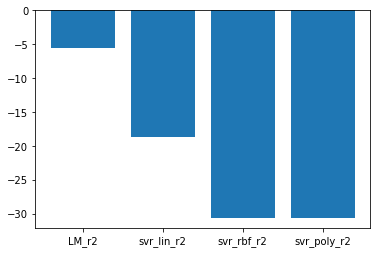

In [190]:
c_val = 0.1
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)
LM_pred = model_LM.fit(X_train, Y_train).predict(X_test)
svr_lin_pred = svr_lin.fit(X_train,Y_train).predict(X_test)
svr_rbf_pred = svr_rbf.fit(X_train,Y_train).predict(X_test)
svr_poly_pred = svr_rbf.fit(X_train,Y_train).predict(X_test)
X_test.reset_index(inplace = True)
X_test.drop(columns = [X_test.columns[0]],inplace = True)
print(len(LM_pred))
print(X_test)
# plt.scatter(X_test["DEXJPUS"],LM_pred, c='magenta')
# plt.show()
LM_MSE = metrics.mean_squared_error(Y_test, LM_pred)
LM_r2 = metrics.r2_score(Y_test, LM_pred)
print (LM_MSE)
print(LM_r2)

svr_lin_MSE = metrics.mean_squared_error(Y_test, svr_lin_pred)
svr_lin_r2 = metrics.r2_score(Y_test, svr_lin_pred)
print (svr_lin_MSE)
print(svr_lin_r2)


svr_rbf_MSE = metrics.mean_squared_error(Y_test, svr_rbf_pred)
svr_rbf_r2 = metrics.r2_score(Y_test, svr_rbf_pred)
print (svr_rbf_MSE)
print(svr_rbf_r2)

svr_poly_MSE = metrics.mean_squared_error(Y_test, svr_poly_pred)
svr_poly_r2 = metrics.r2_score(Y_test, svr_poly_pred)
print (svr_poly_MSE)
print(svr_poly_r2)

# plt.bar(["LM_MSE","svr_lin_MSE","svr_rbf_MSE","svr_poly_MSE"],[LM_MSE,svr_lin_MSE,svr_rbf_MSE,svr_poly_MSE])
plt.bar(["LM_r2","svr_lin_r2","svr_rbf_r2","svr_poly_r2"],[LM_r2,svr_lin_r2,svr_rbf_r2,svr_poly_r2])
plt.show()